In [ ]:
##Importing the necessary libraries 
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.keras.applications.inception_v3 import InceptionV3
import numpy as np
import pandas as pd
import gc
import cv2
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from keras.applications import DenseNet121
from matplotlib import pyplot as plt
from keras.utils import to_categorical
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# gc.collect performs a blocking garbage collection of all generations. Objects that are no longer in use or 
# are inaccessible from the root are candidates for garbage collection.
gc.collect()
# getting the train.csv file from drive
train_df = pd.read_csv(r'/content/gdrive/My Drive/plant-pathology-2020-fgvc7/train.csv')
train_df = train_df.sample(frac = 1)
train_x_images = np.array(train_df['image_id'])
train_y = []
for i,j in train_df.iterrows():
    train_y.append(list(j)[1:])
train_y = np.array(train_y)
file_name = np.array(train_df['image_id'])
train_X = []
gc.collect()
for i in file_name:
    image = (cv2.imread(r"/content/gdrive/My Drive/plant-pathology-2020-fgvc7/images/" + i + ".jpg"))
    resized = cv2.resize(image, (350,234), interpolation = cv2.INTER_AREA)
    train_X.append(resized - [50,50,50])

In [ ]:
# channel distributions
red_values = [np.mean(train_X[idx][:, :, 0]) for idx in range(len(train_X))]
green_values = [np.mean(train_X[idx][:, :, 1]) for idx in range(len(train_X))]
blue_values = [np.mean(train_X[idx][:, :, 2]) for idx in range(len(train_X))]
values = [np.mean(train_X[idx]) for idx in range(len(train_X))]

In [ ]:
fig = ff.create_distplot([values], group_labels=["Channels"], colors=["purple"])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Distribution of channel values")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig

In [ ]:
# The channel values seem to have a roughly normal distribution centered around 105. 
# The maximum channel activation is 255. This means that the average channel value is less than half the maximum 
# value, which indicates that channels are minimally activated most of the time.

In [ ]:
# Red channel distribution
fig = ff.create_distplot([red_values], group_labels=["R"], colors=["red"])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Distribution of red channel values")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig

The red channel values seem to roughly normal distribution, but with a slight rightward (positive skew). This indicates that the red channel tends to be more concentrated at lower values, at around 100. There is large variation in average red values across images.

In [ ]:
# Green channel distribution
fig = ff.create_distplot([green_values], group_labels=["G"], colors=["green"])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Distribution of green channel values")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig

The green channel values have a more uniform distribution than the red channel values, with a smaller peak. The distribution also has a leftward skew (in contrast to red) and a larger mode of around 140. This indicates that green is more pronounced in these images than red, which makes sense, because these are images of leaves!

In [ ]:
# Blue channel Distribution
fig = ff.create_distplot([blue_values], group_labels=["B"], colors=["blue"])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Distribution of blue channel values")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig

The blue channel has the most uniform distribution out of the three color channels, with minimal skew (slight leftward skew). The blue channel shows great variation across images in the dataset.

In [ ]:
#All channel values (together)
fig = go.Figure()

for idx, values in enumerate([red_values, green_values, blue_values]):
    if idx == 0:
        color = "Red"
    if idx == 1:
        color = "Green"
    if idx == 2:
        color = "Blue"
    fig.add_trace(go.Box(x=[color]*len(values), y=values, name=color, marker=dict(color=color.lower())))
    
fig.update_layout(yaxis_title="Mean value", xaxis_title="Color channel",
                  title="Mean value vs. Color channel", template="plotly_white")

In [ ]:
fig = ff.create_distplot([red_values, green_values, blue_values],
                         group_labels=["R", "G", "B"],
                         colors=["red", "green", "blue"])
fig.update_layout(title_text="Distribution of all channel values", template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig.data[2].marker.line.color = 'rgb(0, 0, 0)'
fig.data[2].marker.line.width = 0.5
fig

In [ ]:
# Visualizing the targets
# Healthy leaves distribution
train_df["Healthy"] = train_df["healthy"].apply(bool).apply(str)
fig = px.histogram(train_df, x="Healthy", title="Healthy distribution", color="Healthy",\
            color_discrete_map={
                "True": px.colors.qualitative.Plotly[0],
                "False": px.colors.qualitative.Plotly[1]})
fig.update_layout(template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig

We can see that there are more unhealthy (healthy == 0) plants than healthy (healthy == 1) ones. There are 1305 (72%) unhealthy plants and 516 (28%) healthy plants.

In [ ]:
# Distribution of scab leaves
train_df["Scab"] = train_df["scab"].apply(bool).apply(str)
fig = px.histogram(train_df, x="Scab", color="Scab", title="Scab distribution",\
            color_discrete_map={
                "True": px.colors.qualitative.Plotly[1],
                "False": px.colors.qualitative.Plotly[0]})
fig.update_layout(template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig

We can see that there are more plants without scab (scab == 0) than those with scab (scab == 1). There are 592 (33%) unhealthy plants and 1229 (67%) healthy plants.

In [ ]:
# Rust leaves distribution
train_df["Rust"] = train_df["rust"].apply(bool).apply(str)
fig = px.histogram(train_df, x="Rust", color="Rust", title="Rust distribution",\
            color_discrete_map={
                "True": px.colors.qualitative.Plotly[1],
                "False": px.colors.qualitative.Plotly[0]})
fig.update_layout(template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig

We can see that there are more plants without rust (rust == 0) than those with rust (rust == 1). There are 622 (34%) unhealthy plants and 1199 (66%) healthy plants. We can see that the "unhealthy" percentage is very similar for both rust and scab.

In [ ]:
# Multiple leaves distibution
train_df["Multiple diseases"] = train_df["multiple_diseases"].apply(bool).apply(str)
fig = px.histogram(train_df, x="Multiple diseases", color="Multiple diseases", title="Multiple diseases distribution",\
            color_discrete_map={
                "True": px.colors.qualitative.Plotly[1],
                "False": px.colors.qualitative.Plotly[0]})
fig.update_layout(template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig

We can see that very few leaves have multiple diseases (it is a very occurance). There are 91 (5%) unhealthy plants and 1730 (95%) healthy plants.

In [ ]:
# pie chart for targets
fig = go.Figure([go.Pie(labels=train_df.columns[1:],
           values=train_df.iloc[:, 1:].sum().values)])
fig.update_layout(title_text="Pie chart of targets", template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.show()

In the pie chart above, we can see that most leaves in the dataset are unhealthy (71.7%). Only 5% of plants have multiple diseases, and "rust" and "scab" occupy approximately one-third of the pie each.

#**Image preprocessing and augmentation**

**Canny edge detection** 

Canny is a popular edge detection algorithm, and as the name suggests, it detects the edges of objects present in an image. It was developed by John F. Canny in 1986. The algorithm involves several steps.

1) Noise reduction: Since edge detection is susceptible to noise in an image, we remove the noise in the image using a 5x5 Gaussian filter.
Finding Intensity Gradient of the Image: The smoothened image is then filtered with a Sobel kernel in both horizontal and vertical directions to get the first derivative in the horizontal (Gx) and vertical (Gy) directions. From these two images, one can find the edge gradient and direction for each pixel:
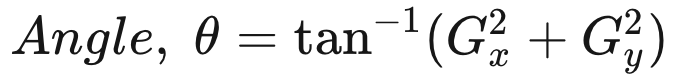
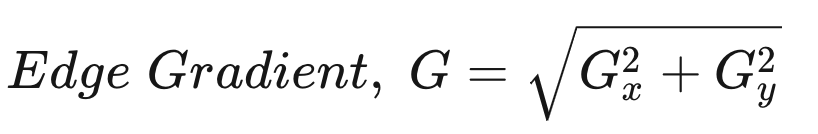
**1)Rounding**: The gradient is always perpendicular to edges. So, it is rounded to one of the four angles representing vertical, horizontal and two diagonal directions.

**2)Non-maximum suppression:** After getting the gradient magnitude and direction, a full scan of the image is done to remove any unwanted pixels which may not constitute the edge. For this, we check every pixel for being a local maximum in its neighborhood in the direction of the gradient.

3)Hysteresis Thresholding: This stage decides which parts are edges and which are not. For this, we need two threshold values, minVal and maxVal. Any edges with intensity gradient greater than maxVal are considered edges and those lesser than minVal are considered non-edges, and discarded. Those who lie between these two thresholds are classified edges or non-edges based on their neighborhood. If they are near “sure-edge” pixels, they are considered edges, and otherwise, they are discarded.

The result of these five steps is a two-dimensional binary map (0 or 255) indicating the location of edges on the image. Canny edge is demonstrated below with a few leaf images:

In [ ]:
# edge detection for visualization
def edge_and_cut(img):
    emb_img = img.copy()
    edges = cv2.Canny(img, 100, 200)
    edge_coors = []
    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            if edges[i][j] != 0:
                edge_coors.append((i, j))
    
    row_min = edge_coors[np.argsort([coor[0] for coor in edge_coors])[0]][0]
    row_max = edge_coors[np.argsort([coor[0] for coor in edge_coors])[-1]][0]
    col_min = edge_coors[np.argsort([coor[1] for coor in edge_coors])[0]][1]
    col_max = edge_coors[np.argsort([coor[1] for coor in edge_coors])[-1]][1]
    new_img = img[row_min:row_max, col_min:col_max]
    
    emb_img[row_min-10:row_min+10, col_min:col_max] = [255, 0, 0]
    emb_img[row_max-10:row_max+10, col_min:col_max] = [255, 0, 0]
    emb_img[row_min:row_max, col_min-10:col_min+10] = [255, 0, 0]
    emb_img[row_min:row_max, col_max-10:col_max+10] = [255, 0, 0]
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 20))
    ax[0].imshow(img)#, cmap='gray')
    ax[0].set_title('Original Image', fontsize=24)
    ax[1].imshow(edges, cmap='gray')
    ax[1].set_title('Canny Edges', fontsize=24)
    ax[2].imshow(emb_img, cmap='gray')
    ax[2].set_title('Bounding Box', fontsize=24)
    plt.show()

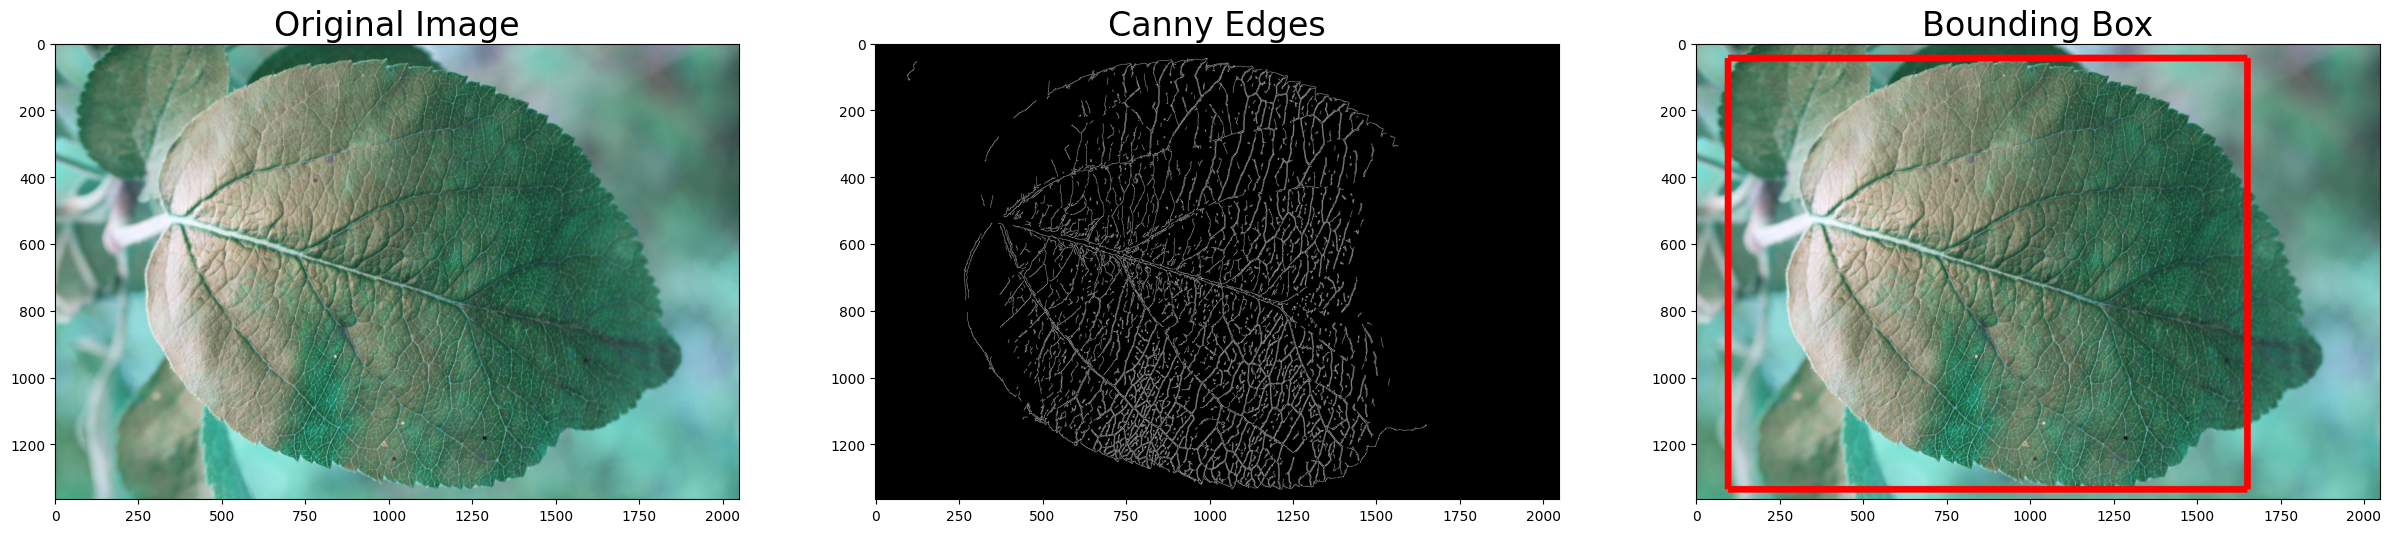

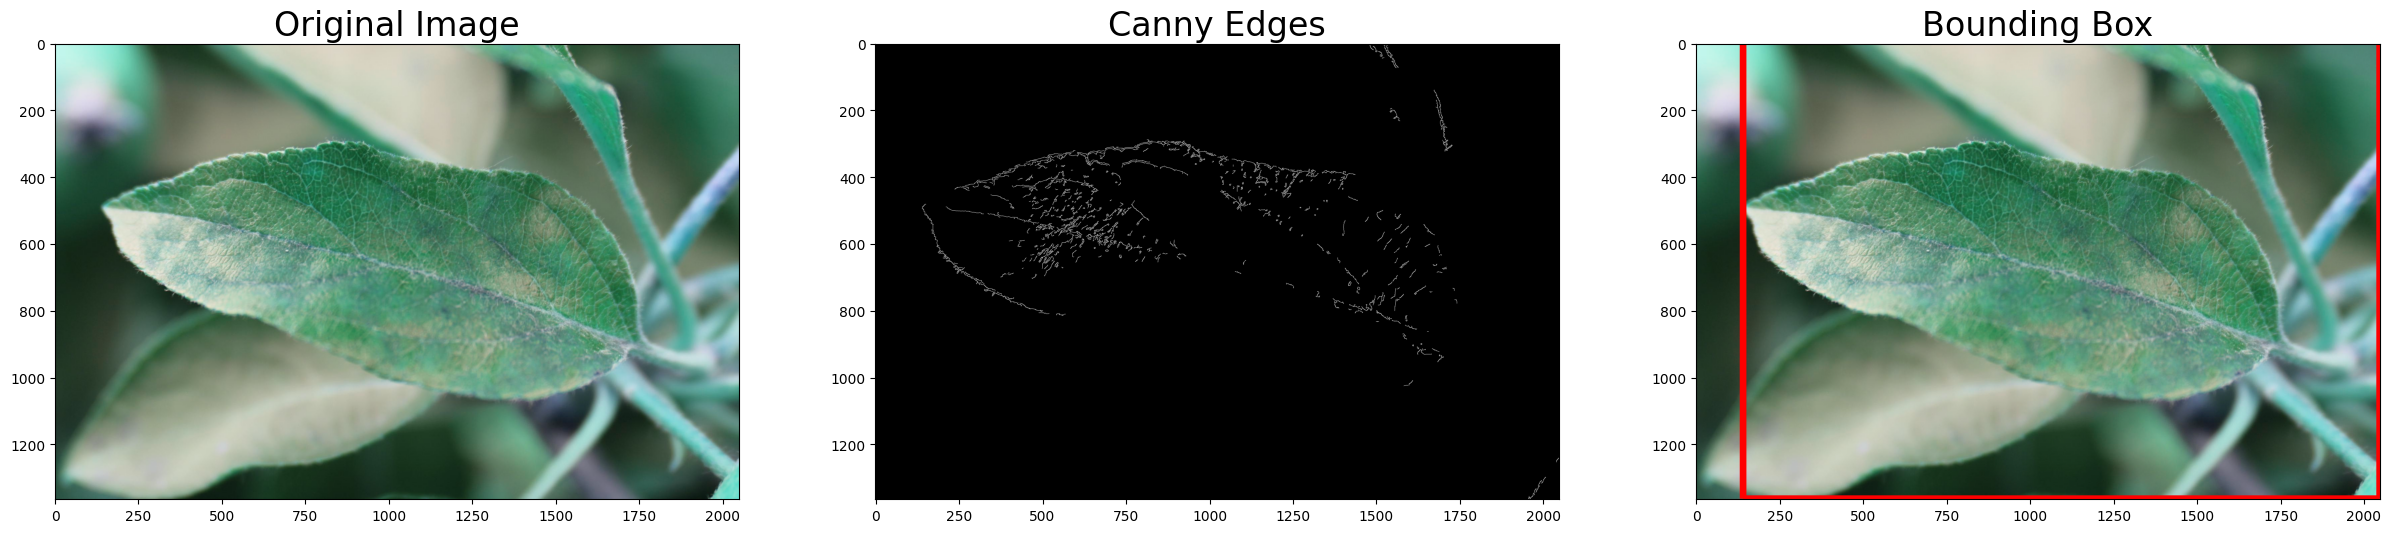

In [ ]:
file_path = "Train_5" + ".jpg"
IMAGE_PATH = r'/content/gdrive/My Drive/plant-pathology-2020-fgvc7/images/Train_5.jpg'
image1 = cv2.imread(IMAGE_PATH)
edge_and_cut(image)
image2 = cv2.imread(r'/content/gdrive/My Drive/plant-pathology-2020-fgvc7/images/Train_7.jpg')
edge_and_cut(image2)
#edge_and_cut(train_images[5])

**Flipping** 

Flipping is a simple transformation that involves index-switching on the image channels. In vertical flipping, the order of rows is exchanged, whereas in vertical flipping, the order of rows is exchanged. Let us assume that Aijk (of size (m, n, 3)) is the image we want to flip. Horizontal and vertical flipping can be represented by the transformations below:

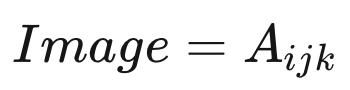

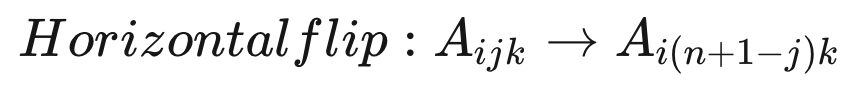
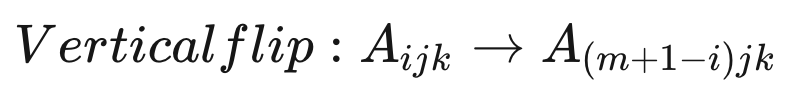

We can see that the order of columns is exchanged in horizontal flipping. While the i and k indices remain the same, the j index reverses. Whereas, in vertical flipping, the order of rows is exchanged in horizontal flipping. While the j and k indices remain the same, the i index reverses.

In [ ]:
# flipping the image
def invert(img):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 20))
    ax[0].imshow(img)
    ax[0].set_title('Original Image', fontsize=24)
    ax[1].imshow(cv2.flip(img, 0))
    ax[1].set_title('Vertical Flip', fontsize=24)
    ax[2].imshow(cv2.flip(img, 1))
    ax[2].set_title('Horizontal Flip', fontsize=24)
    plt.show()

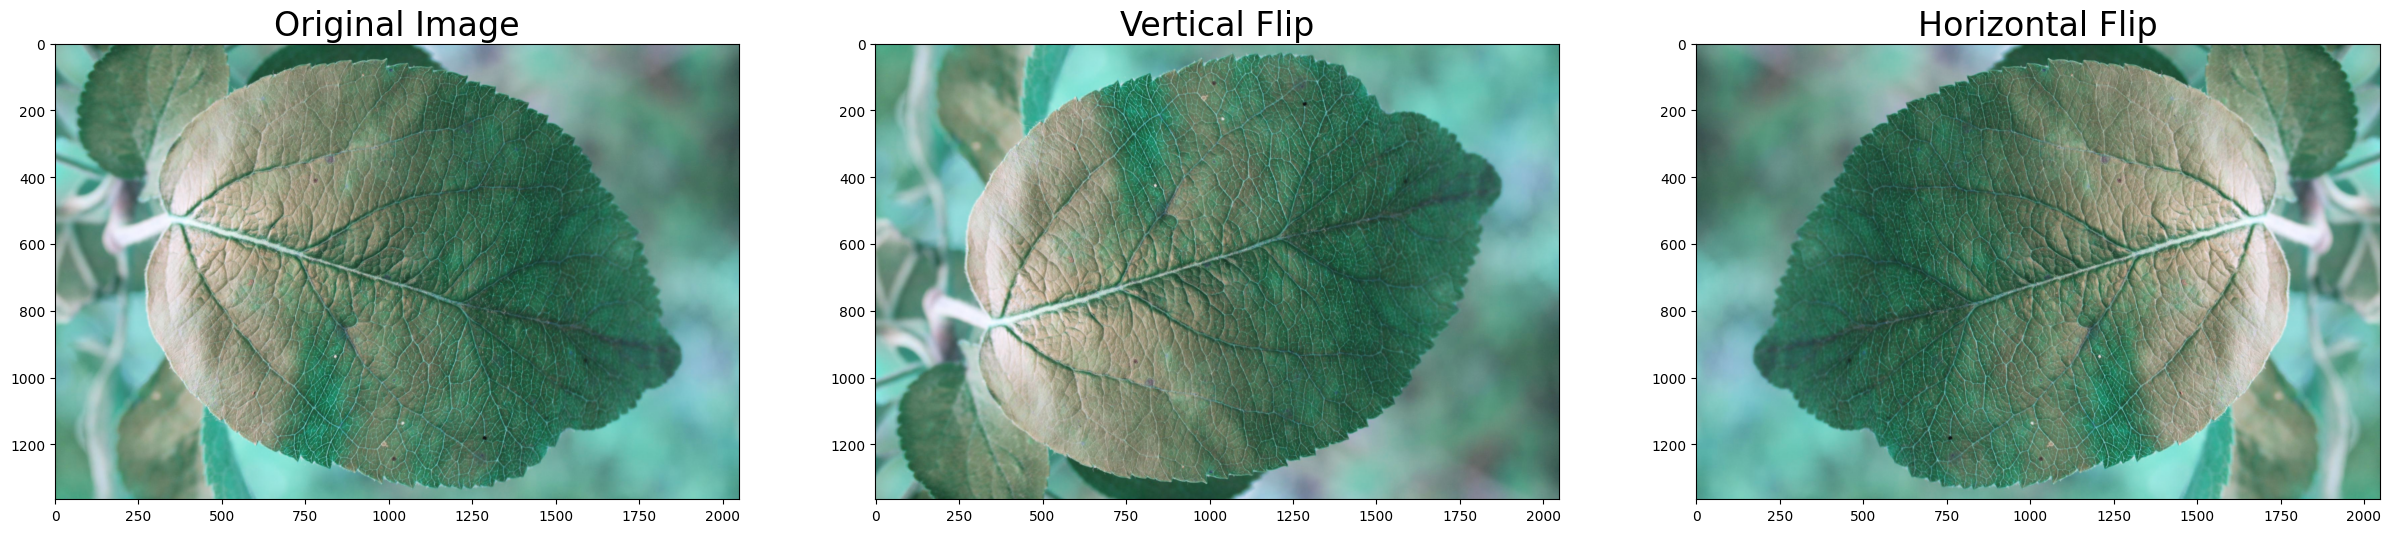

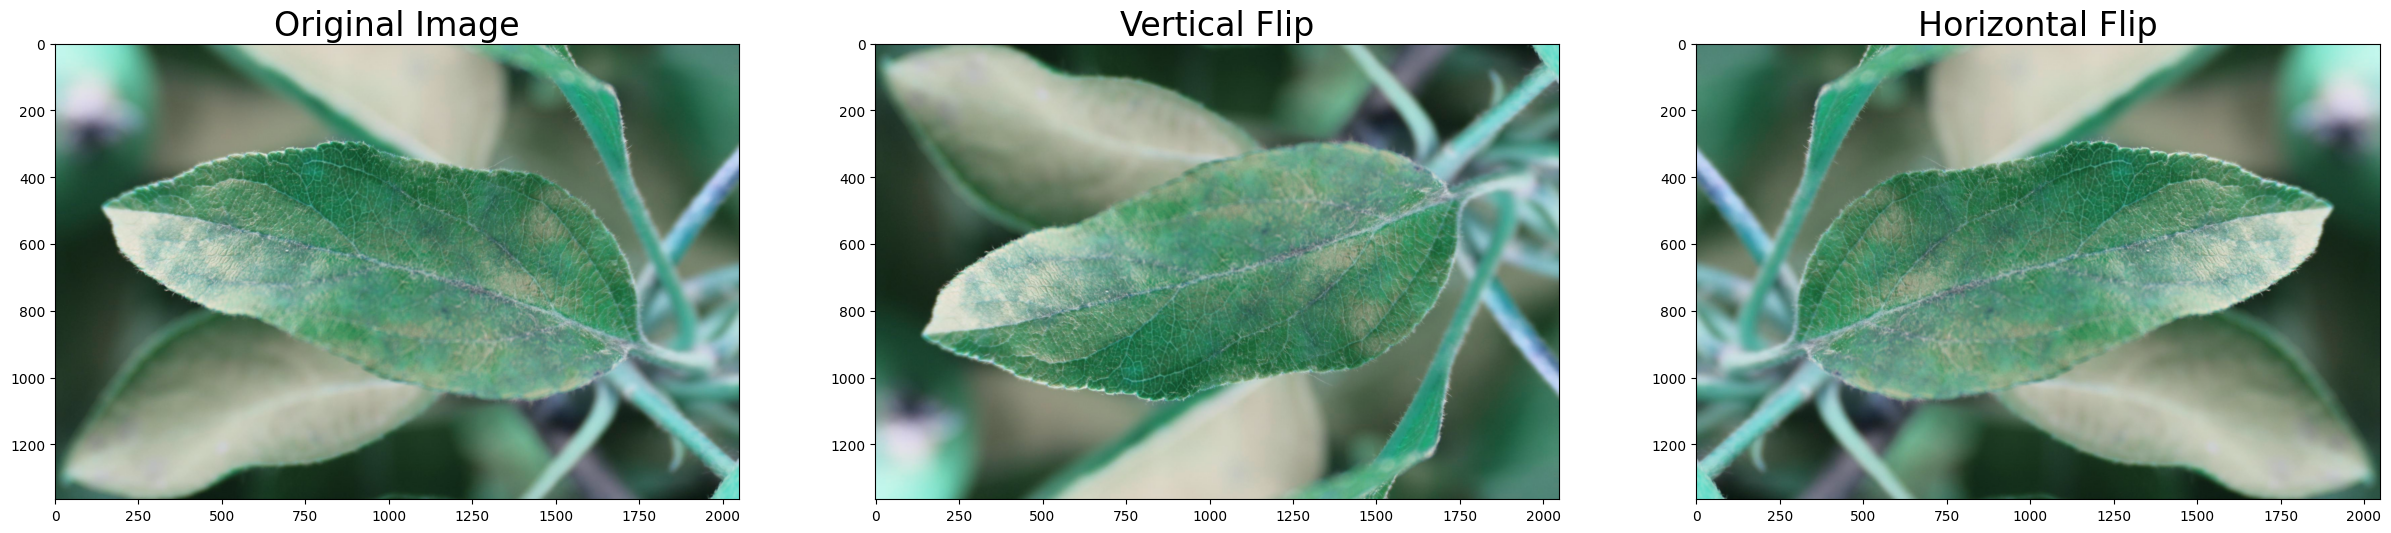

In [ ]:
invert(image1)
invert(image2)

In [ ]:
print(train_df)

        image_id  healthy  multiple_diseases  rust  scab
84      Train_84        0                  0     0     1
681    Train_681        0                  0     0     1
217    Train_217        0                  0     0     1
581    Train_581        0                  0     0     1
852    Train_852        0                  0     1     0
...          ...      ...                ...   ...   ...
1508  Train_1508        1                  0     0     0
1021  Train_1021        0                  0     1     0
1100  Train_1100        0                  0     0     1
1554  Train_1554        0                  1     0     0
427    Train_427        1                  0     0     0

[1821 rows x 5 columns]


AxesImage(size=(234, 350))


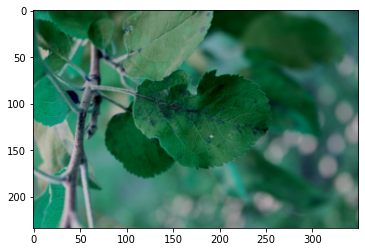

In [ ]:
print(plt.imshow(train_X[0]))

In [ ]:
# training array for training
gc.collect()

cv2.destroyAllWindows()
train_X = np.array(train_X)
training_y = []
for i in train_y:
    training_y.append((np.where(i==1)[0][0]))
training_y = np.array(training_y)

In [ ]:
gc.collect()
# we are taking 0 to 1119 images training and remaining for testing 
training_X = train_X[0:1120]
train_y = training_y [0:1120]
test_X = train_X[1120:1821]
test_Y = training_y[1120:1821]

In [ ]:
gc.collect()
# we are creating imagedatagenerator from keras augmentation. Here we are rotating, horizntally flipping and the fill mode 
# nearest to fill the gap when we resize the image
train_datagen = ImageDataGenerator(
#     rescale=1. / 255,
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# we are using xception model from keras and loading the pretrained weights from imagnet, We are using relu activation funtion in 
# hidden lsayers and softmax activation function in the output layer
model = tf.keras.Sequential([
   tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(234,350,3)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
 
    tf.keras.layers.Dense(512,activation = tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512,activation = tf.nn.relu,kernel_regularizer = tf.keras.regularizers.l2()),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4,activation = tf.nn.softmax)
])

model.compile(optimizer = tf.keras.optimizers.Adamax(),
          loss = 'categorical_crossentropy',
          metrics=['accuracy'])

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
y_binary = to_categorical(training_y)
y_binary_train = to_categorical(train_y)
y_binary_test = to_categorical(test_Y)

In [ ]:
gc.collect()
# we are saving the best model out of all epoachs. We are stoping the model once it reaches 97.7 % accuracy
annealer = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-5)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.977 and logs.get('val_loss')<0.3):
      print("\nReached 97.7% accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
gc.collect()
callbacks = myCallback()
# training the model
history = model.fit_generator(train_datagen.flow(training_X, y_binary_train, batch_size= 32 ),
                              steps_per_epoch=len(training_X) / 32,
                              validation_data = (test_X, y_binary_test),
                              epochs=50,
                              callbacks=[annealer,callbacks],)

<ipython-input-10-624233aafacd>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(training_X, y_binary_train, batch_size= 32 ),


Epoch 1/50
35/35 [==============================] - 78s 1s/step - loss: 4.9688 - accuracy: 0.6116 - val_loss: 7.5020 - val_accuracy: 0.5278 - lr: 0.0010
Epoch 2/50
35/35 [==============================] - 43s 1s/step - loss: 3.2461 - accuracy: 0.8295 - val_loss: 4.3477 - val_accuracy: 0.7233 - lr: 0.0010
Epoch 3/50
35/35 [==============================] - 40s 1s/step - loss: 2.5270 - accuracy: 0.8375 - val_loss: 2.5835 - val_accuracy: 0.8573 - lr: 0.0010
Epoch 4/50
35/35 [==============================] - 43s 1s/step - loss: 2.0081 - accuracy: 0.8670 - val_loss: 1.9287 - val_accuracy: 0.8902 - lr: 0.0010
Epoch 5/50
35/35 [==============================] - 43s 1s/step - loss: 1.7063 - accuracy: 0.8768 - val_loss: 1.6921 - val_accuracy: 0.9030 - lr: 0.0010
Epoch 6/50
35/35 [==============================] - 43s 1s/step - loss: 1.4232 - accuracy: 0.8902 - val_loss: 1.4061 - val_accuracy: 0.9087 - lr: 0.0010
Epoch 7/50
35/35 [==============================] - 43s 1s/step - loss: 1.2878 - a

In [ ]:
# saving the model for future use
#model.save('saved_model/my_model')

In [ ]:
#model.save('my_model.h5')
# saving the model for future use
model.save('/content/gdrive/My Drive/my_model.h5')

In [ ]:
new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
new_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 11, 2048)       20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                        

In [ ]:
# evaluating the model
model.evaluate(test_X, y_binary_test)

In [ ]:
# plotting the training accuracy vs testing accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Val accuracy')
plt.title('Training accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()